In [1]:
import os
import wget
import time
import yaml
import glob
import torch
import random
import inspect
import logging
import datetime
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AdamW, GPT2Config, get_linear_schedule_with_warmup
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, WEIGHTS_NAME, CONFIG_NAME

from language_modeling import LMDataset, LMProcessor
from utils import read_yaml, set_seed, format_time, filter_args, get_device, save, check_folder, save_yaml
from processors import DataProcessor, ModelProcessor
from reporting import Report
from dataset import Dataset

In [2]:
yaml_file = 'fine_tuning_template.yml'

In [3]:
parameters = read_yaml(yaml_file)
check_folder(parameters['output_dir'])
save_yaml(parameters, os.path.join(parameters['output_dir'], 'config.yml'))
logging.basicConfig(filename=os.path.join(parameters['output_dir'], parameters['log_file']), filemode='w+', level=logging.INFO)
logging.info("Parameters fetched.")


In [4]:
logging.info("Setting seed for reproductibility...") 
set_seed(parameters['seed'])
logging.info("\tDone.")

logging.info("Set and retrieve the device on which to run...")
device = get_device()
task = parameters['task'].lower()
logging.info("\tDone.")


There are 0 GPU(s) available.
No GPU available, using the CPU instead.


In [5]:
logging.info("Instanciating dataset and data processor...")
if task in ['language_modeling']:
    data = LMDataset(task, parameters['dataset_name'].lower(), dataset_dir=parameters['dataset_dir'])
    processor = LMProcessor()
logging.info("\tDone.")



In [6]:
logging.info("Fetching data (training + validation) and parameters...")
data._fetch_dataset()
for set_type in ['train', 'dev']:
    data.process_dataset(set_type)
if parameters['do_test']:
    data.process_dataset('test')
logging.info("\tDone.")

logging.info("Fetching pre-trained GPT-2 model: {} and Tokenizer: {} for the task: {}...".format(parameters['pretrained_model'],
                                                                                                parameters['pretrained_tokenizer'],
                                                                                                parameters['task']))


100%|██████████| 207/207 [00:00<00:00, 299489.80it/s]

Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tok


100%|██████████| 177/177 [00:00<00:00, 281102.54it/s]

Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.


100%|██████████| 207/207 [00:00<00:00, 342358.41it/s]


Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.
Tokenizing...
Preprocessing...
Preprocessed.
Tokenized.


In [7]:
if task in ['language_modeling']:
    model = GPT2LMHeadModel.from_pretrained(
                parameters['pretrained_model'],
                output_attentions=parameters['output_attentions'], # Whether the model returns attentions weights.
                output_hidden_states=parameters['output_hidden_states'], # Whether the model returns all hidden-states.
    )
tokenizer = GPT2Tokenizer.from_pretrained(parameters['pretrained_tokenizer'])
model.to(device)
logging.info("\tDone.")



In [8]:
logging.info("Get input examples...")
train_examples = processor.get_train_examples(data)
dev_examples = processor.get_dev_examples(data)
if parameters['do_test']:
    test_examples = processor.get_test_examples(data)
logging.info("\tDone.")



In [9]:
 parameters['max_length']

64

In [10]:
logging.info("Get input features...")
train_features = processor.convert_examples_to_features(train_examples, parameters['max_length'], tokenizer) 
dev_features = processor.convert_examples_to_features(dev_examples, parameters['max_length'], tokenizer)
if parameters['do_test']:
    test_features = processor.convert_examples_to_features(test_examples, parameters['max_length'], tokenizer) 
logging.info("\tDone.")
    


100%|██████████| 1560/1560 [00:07<00:00, 217.19it/s]


In [11]:
logging.info("Creating data loaders...")
train_dataloader = processor.get_data_loader(train_features, 
                                                batch_size=parameters['batch_size'], 
                                                local_rank=parameters['local_rank'], 
                                                set_type='train')
dev_dataloader = processor.get_data_loader(dev_features, 
                                            batch_size=parameters['batch_size'], 
                                            local_rank=parameters['local_rank'], 
                                            set_type='dev')
if parameters['do_test']:
    test_dataloader = processor.get_data_loader(test_features, 
                                                batch_size=parameters['batch_size'], 
                                                local_rank=parameters['local_rank'], 
                                                set_type='test')
logging.info("\tDone.")



In [12]:
logging.info("Creating optimizer and learning rate scheduler...")
optimizer = AdamW(
                model.parameters(),
                lr=float(parameters['learning_rate']),
                eps=float(parameters['adam_epsilon'])
            )
total_steps = len(train_dataloader) * parameters['nb_epochs'] # Total number of training steps is [nb batches] x [nb epochs]. 
scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=parameters['num_warmup_steps'],
                num_training_steps=total_steps
            )
logging.info("\tDone.")

logging.info("Fine-tuning the model.")
model_processor = ModelProcessor(model, optimizer, tokenizer, 
                                    scheduler, device, 
                                    parameters['metric_name'], 
                                    parameters['nb_epochs'],
                                    parameters['use_output_mask'])


In [13]:
len(train_dataloader)

49

In [14]:
training_stats = model_processor.train(train_dataloader, dev_dataloader, parameters['output_dir'])


0it [00:00, ?it/s]


======== Epoch 1 / 3 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
6it [00:34,  5.76s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_1


12it [01:14,  6.03s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_2


18it [01:53,  5.83s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_3


24it [02:30,  5.58s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_4


30it [03:06,  5.56s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_5


36it [03:40,  5.07s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_6


42it [04:15,  5.34s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_7


48it [04:50,  5.16s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_8


49it [05:00,  6.13s/it]



  Average training loss: 4.64
  Training epcoh took: 0:05:01
Running Validation...


0it [00:00, ?it/s]

  Accuracy: 0.00
  Validation Loss: 6.74
  Validation took: 0:01:18

======== Epoch 2 / 3 ========
Training...


6it [00:35,  5.62s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_9


12it [01:11,  5.45s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_10


18it [01:47,  5.30s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_11


24it [02:22,  5.32s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_12


30it [02:59,  5.46s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_13


36it [03:34,  5.23s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_14


42it [04:12,  5.68s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_15


48it [04:52,  6.19s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_16


49it [05:02,  6.18s/it]



  Average training loss: 3.43
  Training epcoh took: 0:05:03
Running Validation...


0it [00:00, ?it/s]

  Accuracy: 0.00
  Validation Loss: 6.16
  Validation took: 0:01:19

======== Epoch 3 / 3 ========
Training...


6it [00:30,  5.11s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_17


12it [01:05,  5.14s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_18


18it [01:40,  5.27s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_19


24it [02:17,  5.44s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_20


30it [02:53,  5.48s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_21


36it [03:34,  6.36s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_22


42it [04:15,  5.96s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_23


48it [04:51,  5.45s/it]

Saving model to ./LM_LPP_GPT2/checkpoint_24


49it [05:01,  6.15s/it]



  Average training loss: 3.25
  Training epcoh took: 0:05:02
Running Validation...
  Accuracy: 0.00
  Validation Loss: 6.04
  Validation took: 0:01:14

Training complete!
Total training took 0:18:56 (h:mm:ss)


Running Validation...
  Accuracy: 0.00
  Validation Loss: 6.04
  Validation took: 0:01:14
Saving model to ./LM_LPP_GPT2/fine_tuned


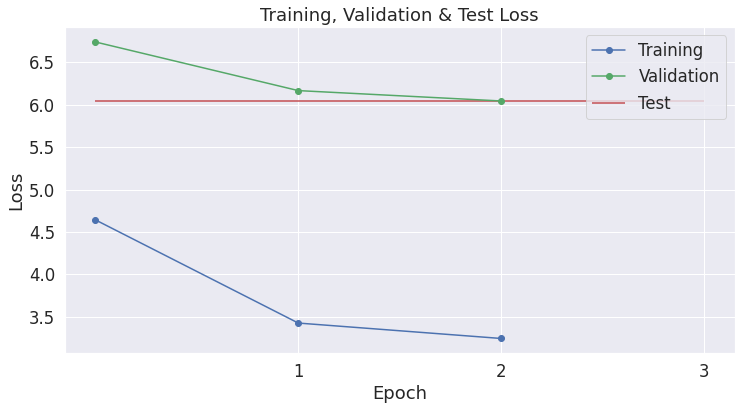

In [17]:
logging.info("Validation reports: ")
#for stat in training_stats:
#    logging.info(stat['report'])
test_accuracy, test_loss = None, None
if parameters['do_test']:
    logging.info("Evaluation report: ")
    test_accuracy, test_loss, test_time = model_processor.evaluate(test_dataloader) 
    #logging.info(report)
logging.info("\tDone.")

logging.info("Saving fine-tuned model to {}...".format(os.path.join(parameters['output_dir'], 'fine_tuned')))
save(model, tokenizer, parameters['output_dir'], 'fine_tuned')
logging.info("\tDone.")

logging.info("Plotting training and validation losses...")
Report.plots_train_val_loss(training_stats, parameters['nb_epochs'], 
                            os.path.join(parameters['output_dir'], 'train_val_loss.png'), 
                            test_accuracy=test_accuracy, test_loss=test_loss)
logging.info("\tDone.")